In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import sys
import os
sys.path.append(os.path.abspath('../'))

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sprawozdanie.model_service import *
dataset = pd.read_csv('../data/numerical_dataset_original.csv')

## 3. Preprocessing

Po wstępnej analizie i eksperymentach z kilkoma modelami okazało się, że zaproponowany podział zbioru danych na zbiory treningowy, testowy i walidacyjny prowadzi do dziwnych rezultatów — np. testowany model XGBClassifier uzyskuje zupełnie różne wartości metryki precyzji.

Zdecydowano się więc na własny podział tylko na zbiory treningowy i testowy oraz przesunięcie procesu przygotowania danych bezpośrednio przed treningiem modelu.

Usunięto kolumny metadanych, które nie są potrzebne do trenowania modelu. Pozostawiono jedynie kolumny: cik, label oraz cechy (features).
Kolumna cik jest potrzebna do grupowania danych oraz operacji spłaszczania i przywracania struktury (flattening / deflattening).

In [2]:
dataset = pd.read_csv('../data/numerical_dataset_original.csv')
dataset.drop(['cik', 'subset', 'ticker', 'Fiscal Period'], axis=1, inplace=True)
dataset.head()

,label,Cost of Goods Sold,Depreciation Depletion Amortization,EBIT,EBITDA,Gross Profit,Long-Term Debt,Market Cap,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
0,False,246.5,5.5,30.0,35.5,56.2,3.9,171.0,33.6,-113.7,302.7,275.1,154.0,117.6,77.1,207.3,26.2,96.2
1,False,268.5,6.9,18.6,25.5,56.6,0.6,203.3,36.3,-77.4,325.2,307.8,185.3,123.7,77.1,201.2,38.0,110.8
2,False,312.1,8.8,20.9,29.7,60.8,0.1,185.0,12.1,-65.4,372.9,335.6,221.0,132.2,77.1,211.1,39.9,160.0
3,False,337.3,9.3,30.7,40.0,77.4,0.1,309.4,19.4,-45.9,414.6,362.9,234.3,144.2,77.1,215.4,46.6,179.7
4,False,402.3,14.7,2.2,16.9,79.0,79.2,196.4,0.0,-45.9,481.3,478.5,248.2,178.4,77.1,325.1,77.7,199.3


### 3.1 Podział na zbiory test i train

In [4]:
dataset = split_train_test(dataset, 2025, 0.1)
dataset.head()
dataset.shape

(22330, 19)

### 3.2 Nadpróbkowanie SMOTE

Zbiór wymaga zbalansowania klas, poniewaz spółek bankrutujących jest znacznie mniej.

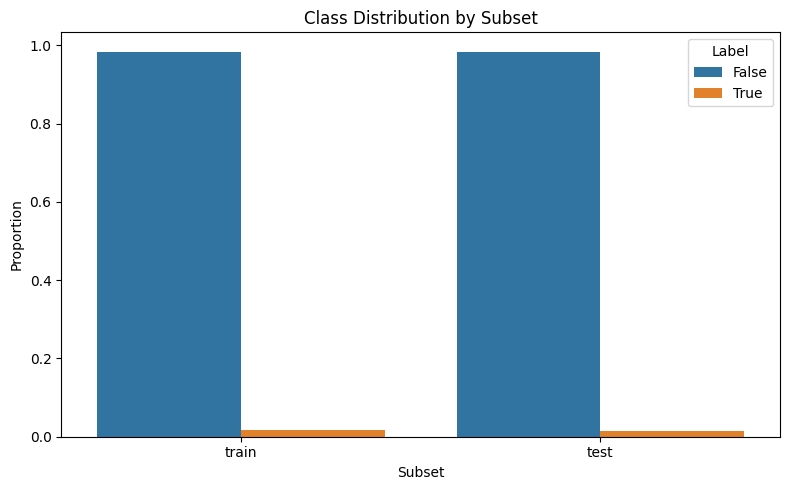

In [9]:
subsets = ['train', 'test']
data = []
for subset in subsets:
    counts = dataset[dataset['subset'] == subset]['label'].value_counts(normalize=True)
    for label, proportion in counts.items():
        data.append({'subset': subset, 'label': label, 'proportion': proportion})

df_plot = pd.DataFrame(data)

plt.figure(figsize=(8, 5))
sns.barplot(data=df_plot, x='subset', y='proportion', hue='label', order=subsets, hue_order=[False, True])
plt.title('Class Distribution by Subset')
plt.ylabel('Proportion')
plt.xlabel('Subset')
plt.legend(title='Label')
plt.tight_layout()
plt.show()

In [5]:
flatten_dataset = flatten_financial_dataset(dataset, 5)
flatten_dataset = oversample_train_subset(flatten_dataset, 2025)
dataset = deflatten_financial_dataset(flatten_dataset)
dataset.head()
dataset.shape

(41755, 19)

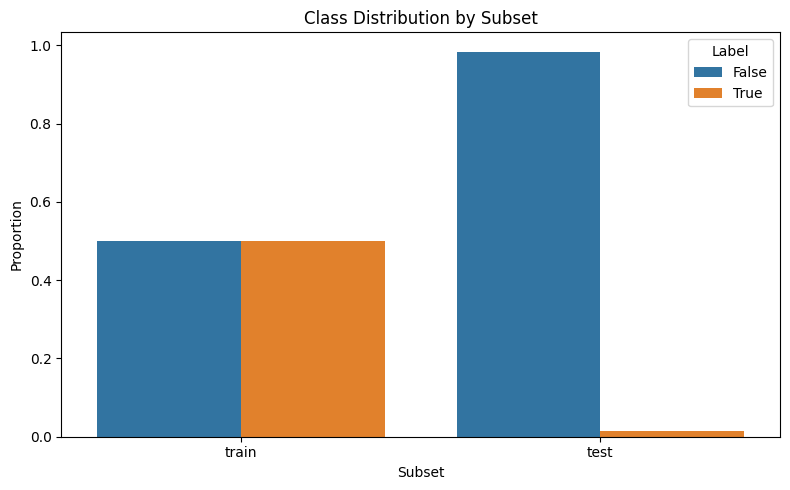

In [11]:
subsets = ['train', 'test']
data = []
for subset in subsets:
    counts = dataset[dataset['subset'] == subset]['label'].value_counts(normalize=True)
    for label, proportion in counts.items():
        data.append({'subset': subset, 'label': label, 'proportion': proportion})

df_plot = pd.DataFrame(data)

plt.figure(figsize=(8, 5))
sns.barplot(data=df_plot, x='subset', y='proportion', hue='label', order=subsets, hue_order=[False, True])
plt.title('Class Distribution by Subset')
plt.ylabel('Proportion')
plt.xlabel('Subset')
plt.legend(title='Label')
plt.tight_layout()
plt.show()

### 3.5 Wzbogacanie danych (Data Enrichment)
W zbiorze danych brakuje kilku ważnych wskaźników finansowych, jednak można je wyliczyć na podstawie już dostępnych cech.

In [16]:
dataset = calculate_ratios(dataset)
dataset.columns
dataset.head()

,label,subset,Cost of Goods Sold,Depreciation Depletion Amortization,EBIT,EBITDA,Gross Profit,Long-Term Debt,Market Cap,Net Income,...,ROA percentage,Current Ratio,Quick Ratio,Liabilities-to-Assets Ratio,Total Equity,Equity-to-Asset,Asset Turnover,Receivables Turnover,Inventory Turnover,PE Ratio
0,False,train,246.5,5.5,30.0,35.5,56.2,3.9,171.0,33.6,...,12.21,1.31,0.65,0.75,67.8,0.25,1.10,3.15,3.20,5.09
1,False,train,268.5,6.9,18.6,25.5,56.6,0.6,203.3,36.3,...,11.79,1.50,0.87,0.65,106.6,0.35,1.06,2.94,3.48,5.60
2,False,train,312.1,8.8,20.9,29.7,60.8,0.1,185.0,12.1,...,3.61,1.67,1.09,0.63,124.5,0.37,1.11,2.33,4.05,15.29
3,False,train,337.3,9.3,30.7,40.0,77.4,0.1,309.4,19.4,...,5.35,1.62,1.09,0.59,147.5,0.41,1.14,2.31,4.37,15.95
4,False,train,402.3,14.7,2.2,16.9,79.0,79.2,196.4,0.0,...,0.00,1.39,0.96,0.68,153.4,0.32,1.01,2.41,5.22,0.00


Sprawdzamy teraz, czy wskaźniki zostały obliczone poprawnie. Porównamy uzyskane wartości ze wskaźnikami ze strony: https://www.gurufocus.com/stock/ADNT/financials.
Porównanie zostanie przeprowadzone dla spółek o tickerach: ADNT i PAYX, ponieważ mają one stosunkowo świeże dane (do 2021 roku) i są łatwo dostępne na portalu GuruFocus.

Dopasowane wskaźniki:
- Net Profit Margin (marża zysku netto)
- EBITDA Margin (marża EBITDA)

- Gross Profit Margin (marża zysku brutto)

- Current Ratio (wskaźnik płynności bieżącej)

- Quick Ratio (wskaźnik płynności szybkiej)

- Liabilities-to-Assets Ratio (stosunek zobowiązań do aktywów)

- Asset Turnover Ratio (rotacja aktywów)

- P/E Ratio (wskaźnik cena/zysk)

- Receivables Turnover – podobny, różnica wynika z użycia „Total Receivables” zamiast „Average Accounts Receivable”

- Inventory Turnover – podobny, różnica wynika z użycia „Total Inventories” zamiast „Average Inventory”

- ROA (zwrot z aktywów) – prawie taki sam, różnica wynika z użycia „Total Assets” zamiast „Average Total Assets”

- Equity-to-Asset – prawie taki sam, różnica wynika z użycia „Total Assets” zamiast „Average Total Assets”

Po sprawdzeniu danych, okazało się, że są wskaźniki których nie da się wyliczyć z istniejących wartości lub nie są poprawne, więc je usunięto:
- Operating Profit Margin – wymaga cechy Operating Income, której nie ma w zbiorze danych. Zastąpienie jej przez EBIT byłoby błędne, ponieważ EBIT liczy się inaczej.

- Debt to Equity Ratio – = Total Liabilities / Shareholders' Equity, gdzie Shareholders' Equity = Total Assets - Total Liabilities, ale obliczenia nie są poprawne.

- Debt to Assets Ratio – nie można obliczyć, ponieważ brakuje cechy Total Debt.

- Enterprise Value (EV) – = Market Cap + Total Debt - Cash and Cash Equivalents, ale Total Debt oraz Cash and Cash Equivalents nie są dostępne.

- EV/EBITDA Ratio – nie można obliczyć z powodu braku EV.

- ROE – wymaga Shareholders' Equity, której nie ma w zbiorze.

In [33]:
enriched[calculated_features] = enriched[calculated_features].fillna(0)
print(f"Nans in the dataset: {enriched.isnull().sum().sum()}")

Nans in the dataset: 0


In [35]:
metadata_columns_count = 1
enriched_zeros_values_count_per_col = enriched.iloc[:, metadata_columns_count:][enriched == 0].count()
enriched_all_values_count = enriched.iloc[:, metadata_columns_count:].count().sum()
enriched_zeros_values_count_per_col.sort_values(ascending=False)

Depreciation Depletion Amortization    519
Net Profit Margin percentage           467
ROA percentage                         444
PE Ratio                               440
Net Income                             432
EBIT                                   341
EBITDA Margin percentage               320
EBITDA                                 285
Long-Term Debt                         269
Inventory Turnover                     215
Retained Earnings                      203
Receivables Turnover                   146
Asset Turnover                         128
Total Receivables                      128
Equity-to-Asset                        118
Cost of Goods Sold                      96
Total Inventories                       80
Quick Ratio                             69
Gross Profit Margin percentage          67
Gross Profit                            46
Liabilities-to-Assets Ratio             35
Revenue                                 35
Current Ratio                           26
Total Equit

In [36]:
print(f'Percentage of zeros in the dataset: {enriched_zeros_values_count_per_col.sum() / enriched_all_values_count * 100:.2f}%')

Percentage of zeros in the dataset: 0.46%


Zaobserwowano, że odsetek zer w zbiorze danych wzrósł o 0,05%, jednak nadal jest on bardzo niski, co nie wpływa znacząco na jakość danych.

### 3.6 Spłaszaczanie danych

In [ ]:
dataset = flatten_financial_dataset(dataset, 5)

### 3.7 Normalizacja

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
dataset = pd.read_csv('../data/numerical_dataset_original.csv')
dataset[dataset['subset'] == 'test']['label'].value_counts()/5

label
False    667.0
True      11.0
Name: count, dtype: float64